# SRI-Guided Adaptive Encoding Selection & RWSE+SRWE Concatenation Experiment

This notebook demonstrates the **SRI-Guided Adaptive Encoding Selection** experiment, which compares 7 positional-encoding strategies for GPS graph transformers:

1. **FIXED-RWSE** — Random Walk Structural Encoding (baseline)
2. **FIXED-LapPE** — Laplacian Positional Encoding
3. **FIXED-SRWE** — Super-Resolved Walk Encoding (Tikhonov spectral recovery)
4. **SRI-THRESHOLD** — Per-graph adaptive selection based on Spectral Resolution Index
5. **CONCAT-RWSE-SRWE** — Complementary concatenation of RWSE and SRWE
6. **ORACLE** — Per-graph best fixed strategy (upper bound)
7. **LEARNED-SELECTOR** — MLP-based selector

The experiment evaluates these strategies across ZINC-subset, Peptides-func, and Peptides-struct datasets. This demo loads pre-computed results plus graph data from the ZINC-subset, then re-derives the spectral encodings and analyses from the original methodology.

In [1]:
# ── Install dependencies ──
import subprocess, sys

def pip_install(*pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])

# Packages NOT pre-installed in Colab
pip_install("scipy", "scikit-learn")

# Colab-compat: pin versions that match Colab's pre-installed numpy
try:
    import google.colab  # noqa
    _IN_COLAB = True
except ImportError:
    _IN_COLAB = False

if not _IN_COLAB:
    pip_install("numpy<2", "matplotlib")


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# ── Imports ──
import json
import math
import os
import sys
import time
import warnings
from pathlib import Path
from typing import Any

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("Imports complete.")

Imports complete.


In [3]:
# ── Data loading helper ──
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter5_sri_guided_adap/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded data with keys: {list(data.keys())}")
print(f"Datasets: {[ds['dataset'] for ds in data['datasets']]}")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded data with keys: ['metadata', 'datasets']
Datasets: ['ZINC-subset']
  ZINC-subset: 55 examples


## Configuration

Tunable parameters for the encoding computation and analysis. These mirror the original experiment's hyperparameters.

In [5]:
# ── Configuration ──
# Encoding parameters
LAPPE_K = 8          # Number of Laplacian eigenvectors (original: 8)
SRWE_BINS = 20       # Histogram bins for SRWE (original: 20)
SRWE_GRID = 100      # Lambda grid resolution for SRWE (original: 100)
SRWE_REG = 1e-3      # Tikhonov regularisation strength (original: 1e-3)

# Analysis parameters
MAX_EXAMPLES = 55    # Graphs to process for encoding demo (original: all ~1000)
SRI_THRESHOLD = 1.0  # SRI threshold for adaptive strategy selection (original: 1.0)

# Strategies compared in the experiment
STRATEGIES = ['FIXED-RWSE', 'FIXED-LapPE', 'FIXED-SRWE', 'SRI-THRESHOLD', 'CONCAT-RWSE-SRWE']
ALL_STRATEGIES = STRATEGIES + ['ORACLE']

print(f"Config: LAPPE_K={LAPPE_K}, SRWE_BINS={SRWE_BINS}, SRWE_GRID={SRWE_GRID}, MAX_EXAMPLES={MAX_EXAMPLES}")

Config: LAPPE_K=8, SRWE_BINS=20, SRWE_GRID=100, MAX_EXAMPLES=55


## Data Parsing

Parse graph examples from the loaded JSON into adjacency matrices, node features, and spectral annotations (RWSE, eigenvalues, SRI). This mirrors the `load_all_data` function from the original script.

In [6]:
# ── Parse graph examples into structured data ──
zinc_examples = None
for ds in data['datasets']:
    if ds['dataset'] == 'ZINC-subset':
        zinc_examples = ds['examples']
        break

parsed_graphs = []
for ex in zinc_examples[:MAX_EXAMPLES]:
    inp = json.loads(ex['input'])
    edge_index = inp.get('edge_index', [[], []])
    num_nodes = inp.get('num_nodes', 0)
    node_feat = inp.get('node_feat', [])
    spectral = inp.get('spectral', {})

    if num_nodes == 0:
        continue

    # Build adjacency info
    row, col = (edge_index[0], edge_index[1]) if edge_index and len(edge_index) == 2 else ([], [])

    # RWSE from spectral annotations
    rwse = np.array(spectral.get('rwse', []))
    if rwse.size == 0:
        rwse = np.zeros((num_nodes, 20))

    eigenvalues = np.array(spectral.get('eigenvalues', []))

    sri = spectral.get('sri', {})
    sri_K20 = float(sri.get('K=20', 0.0))

    vcond = spectral.get('vandermonde_cond', {})
    vandermonde_cond = float(vcond.get('K=20', 1e15))

    delta_min = float(spectral.get('delta_min', 0.0))

    graph = {
        'num_nodes': num_nodes,
        'edge_row': np.array(row, dtype=int),
        'edge_col': np.array(col, dtype=int),
        'node_feat': np.array(node_feat) if node_feat else np.zeros((num_nodes, 1)),
        'rwse': rwse,
        'eigenvalues': eigenvalues,
        'sri_K20': sri_K20,
        'vandermonde_cond': vandermonde_cond,
        'delta_min': delta_min,
        'target': float(ex['output']),
        'predictions': {
            'FIXED-RWSE': float(ex.get('predict_FIXED_RWSE', 0)),
            'FIXED-LapPE': float(ex.get('predict_FIXED_LapPE', 0)),
            'FIXED-SRWE': float(ex.get('predict_FIXED_SRWE', 0)),
            'SRI-THRESHOLD': float(ex.get('predict_SRI_THRESHOLD', 0)),
            'CONCAT-RWSE-SRWE': float(ex.get('predict_CONCAT_RWSE_SRWE', 0)),
            'ORACLE': float(ex.get('predict_ORACLE', 0)),
        },
    }
    parsed_graphs.append(graph)

print(f"Parsed {len(parsed_graphs)} graphs")
for i, g in enumerate(parsed_graphs):
    print(f"  Graph {i}: {g['num_nodes']} nodes, {len(g['edge_row'])} edges, "
          f"SRI={g['sri_K20']:.4f}, target={g['target']:.4f}")

Parsed 55 graphs
  Graph 0: 22 nodes, 48 edges, SRI=0.0178, target=-0.3406
  Graph 1: 24 nodes, 50 edges, SRI=0.1015, target=0.6493
  Graph 2: 22 nodes, 48 edges, SRI=0.1665, target=-2.5045
  Graph 3: 27 nodes, 58 edges, SRI=0.2429, target=-0.4578
  Graph 4: 28 nodes, 60 edges, SRI=0.2920, target=2.1010
  Graph 5: 29 nodes, 68 edges, SRI=0.3383, target=1.6095
  Graph 6: 29 nodes, 62 edges, SRI=0.3683, target=1.1291
  Graph 7: 19 nodes, 40 edges, SRI=0.4128, target=1.1942
  Graph 8: 21 nodes, 44 edges, SRI=0.4517, target=0.7982
  Graph 9: 26 nodes, 56 edges, SRI=0.4901, target=1.1045
  Graph 10: 27 nodes, 60 edges, SRI=0.5297, target=1.8806
  Graph 11: 34 nodes, 76 edges, SRI=0.5751, target=1.4858
  Graph 12: 27 nodes, 62 edges, SRI=0.6317, target=-0.6336
  Graph 13: 26 nodes, 58 edges, SRI=0.6677, target=3.0295
  Graph 14: 17 nodes, 36 edges, SRI=0.7050, target=-0.7207
  Graph 15: 22 nodes, 46 edges, SRI=0.7351, target=-0.4324
  Graph 16: 30 nodes, 66 edges, SRI=0.7609, target=0.8118
 

## Encoding Computation

Compute the three core positional encodings from the original script:
- **LapPE**: Laplacian Positional Encoding (squared eigenvector components)
- **SRWE**: Super-Resolved Walk Encoding via Tikhonov regularization
- **RWSE**: Random Walk Structural Encoding (pre-computed in the data)

In [7]:
# ── Laplacian Positional Encoding (from original compute_lappe) ──
def compute_lappe(N, edge_row, edge_col, k=LAPPE_K):
    """Compute Laplacian Positional Encoding (squared eigenvector components)."""
    if N < 3 or len(edge_row) == 0:
        return np.zeros((N, k))

    try:
        adj = csr_matrix((np.ones(len(edge_row)), (edge_row, edge_col)), shape=(N, N))
        deg = np.array(adj.sum(axis=1)).flatten()
        deg_inv_sqrt = np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0)
        D_inv_sqrt = csr_matrix((deg_inv_sqrt, (range(N), range(N))), shape=(N, N))
        L = csr_matrix(np.eye(N)) - D_inv_sqrt @ adj @ D_inv_sqrt

        actual_k = min(k, N - 2)
        if actual_k < 1:
            return np.zeros((N, k))

        evals, evecs = eigsh(L, k=actual_k + 1, which='SM', tol=1e-4)
        idx = np.argsort(evals)[1:actual_k + 1]
        result = evecs[:, idx] ** 2  # square to remove sign ambiguity
    except Exception:
        result = np.zeros((N, min(k, max(1, N - 2))))

    # Pad to k dims
    if result.shape[1] < k:
        result = np.pad(result, ((0, 0), (0, k - result.shape[1])))

    return result[:, :k]


# ── Super-Resolved Walk Encoding (from original compute_srwe_graph) ──
def compute_srwe_graph(rwse, n_bins=SRWE_BINS,
                       lambda_range=(-3, 3),
                       n_grid=SRWE_GRID,
                       reg=SRWE_REG):
    """Compute SRWE for all nodes in a graph (vectorized across nodes)."""
    N, K = rwse.shape

    if K == 0 or N == 0:
        return np.zeros((N, n_bins))

    lambda_grid = np.linspace(lambda_range[0], lambda_range[1], n_grid)

    # Vandermonde measurement matrix: V[k,j] = lambda_grid[j]^(k+1)
    V = np.array([lambda_grid ** (k + 1) for k in range(K)])  # (K, n_grid)

    # Tikhonov: W = (V^T V + reg*I)^{-1} V^T M  where M is (K, N)
    VtV = V.T @ V + reg * np.eye(n_grid)
    VtM = V.T @ rwse.T  # (n_grid, N)

    try:
        W = np.linalg.solve(VtV, VtM)  # (n_grid, N)
    except np.linalg.LinAlgError:
        return np.zeros((N, n_bins))

    W = np.maximum(W, 0)  # non-negativity

    # Normalize per node
    totals = W.sum(axis=0, keepdims=True)
    totals = np.where(totals > 1e-10, totals, 1.0)
    W = W / totals  # (n_grid, N)

    # Histogram binning (vectorized)
    bin_width = (lambda_range[1] - lambda_range[0]) / n_bins
    bin_indices = np.clip(
        ((lambda_grid - lambda_range[0]) / bin_width).astype(int),
        0, n_bins - 1
    )  # (n_grid,)

    srwe = np.zeros((N, n_bins))
    for b in range(n_bins):
        mask = (bin_indices == b)
        if mask.any():
            srwe[:, b] = W[mask, :].sum(axis=0)

    return srwe


# ── Compute encodings for parsed graphs ──
print("Computing LapPE and SRWE encodings...")
start = time.time()

for i, g in enumerate(parsed_graphs):
    N = g['num_nodes']

    # LapPE
    g['lappe'] = compute_lappe(N, g['edge_row'], g['edge_col'], k=LAPPE_K)

    # SRWE (using pre-computed RWSE)
    g['srwe'] = compute_srwe_graph(g['rwse'], n_bins=SRWE_BINS,
                                    n_grid=SRWE_GRID, reg=SRWE_REG)

    print(f"  Graph {i}: LapPE shape={g['lappe'].shape}, SRWE shape={g['srwe'].shape}")

elapsed = time.time() - start
print(f"Encoding computation complete in {elapsed:.2f}s")

Computing LapPE and SRWE encodings...


  Graph 0: LapPE shape=(22, 8), SRWE shape=(22, 20)


  Graph 1: LapPE shape=(24, 8), SRWE shape=(24, 20)
  Graph 2: LapPE shape=(22, 8), SRWE shape=(22, 20)
  Graph 3: LapPE shape=(27, 8), SRWE shape=(27, 20)
  Graph 4: LapPE shape=(28, 8), SRWE shape=(28, 20)
  Graph 5: LapPE shape=(29, 8), SRWE shape=(29, 20)


  Graph 6: LapPE shape=(29, 8), SRWE shape=(29, 20)
  Graph 7: LapPE shape=(19, 8), SRWE shape=(19, 20)


  Graph 8: LapPE shape=(21, 8), SRWE shape=(21, 20)
  Graph 9: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 10: LapPE shape=(27, 8), SRWE shape=(27, 20)


  Graph 11: LapPE shape=(34, 8), SRWE shape=(34, 20)
  Graph 12: LapPE shape=(27, 8), SRWE shape=(27, 20)
  Graph 13: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 14: LapPE shape=(17, 8), SRWE shape=(17, 20)


  Graph 15: LapPE shape=(22, 8), SRWE shape=(22, 20)
  Graph 16: LapPE shape=(30, 8), SRWE shape=(30, 20)
  Graph 17: LapPE shape=(18, 8), SRWE shape=(18, 20)
  Graph 18: LapPE shape=(23, 8), SRWE shape=(23, 20)
  Graph 19: LapPE shape=(24, 8), SRWE shape=(24, 20)
  Graph 20: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 21: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 22: LapPE shape=(25, 8), SRWE shape=(25, 20)
  Graph 23: LapPE shape=(13, 8), SRWE shape=(13, 20)


  Graph 24: LapPE shape=(27, 8), SRWE shape=(27, 20)
  Graph 25: LapPE shape=(22, 8), SRWE shape=(22, 20)
  Graph 26: LapPE shape=(29, 8), SRWE shape=(29, 20)
  Graph 27: LapPE shape=(20, 8), SRWE shape=(20, 20)
  Graph 28: LapPE shape=(27, 8), SRWE shape=(27, 20)
  Graph 29: LapPE shape=(18, 8), SRWE shape=(18, 20)
  Graph 30: LapPE shape=(22, 8), SRWE shape=(22, 20)
  Graph 31: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 32: LapPE shape=(24, 8), SRWE shape=(24, 20)
  Graph 33: LapPE shape=(27, 8), SRWE shape=(27, 20)


  Graph 34: LapPE shape=(25, 8), SRWE shape=(25, 20)
  Graph 35: LapPE shape=(30, 8), SRWE shape=(30, 20)
  Graph 36: LapPE shape=(18, 8), SRWE shape=(18, 20)
  Graph 37: LapPE shape=(22, 8), SRWE shape=(22, 20)
  Graph 38: LapPE shape=(20, 8), SRWE shape=(20, 20)
  Graph 39: LapPE shape=(23, 8), SRWE shape=(23, 20)
  Graph 40: LapPE shape=(24, 8), SRWE shape=(24, 20)
  Graph 41: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 42: LapPE shape=(19, 8), SRWE shape=(19, 20)
  Graph 43: LapPE shape=(25, 8), SRWE shape=(25, 20)
  Graph 44: LapPE shape=(25, 8), SRWE shape=(25, 20)


  Graph 45: LapPE shape=(19, 8), SRWE shape=(19, 20)
  Graph 46: LapPE shape=(18, 8), SRWE shape=(18, 20)
  Graph 47: LapPE shape=(20, 8), SRWE shape=(20, 20)
  Graph 48: LapPE shape=(20, 8), SRWE shape=(20, 20)
  Graph 49: LapPE shape=(20, 8), SRWE shape=(20, 20)
  Graph 50: LapPE shape=(26, 8), SRWE shape=(26, 20)


  Graph 51: LapPE shape=(26, 8), SRWE shape=(26, 20)
  Graph 52: LapPE shape=(16, 8), SRWE shape=(16, 20)
  Graph 53: LapPE shape=(14, 8), SRWE shape=(14, 20)
  Graph 54: LapPE shape=(14, 8), SRWE shape=(14, 20)
Encoding computation complete in 3.09s


## Encoding Strategy Dispatch

Demonstrate how the SRI-guided adaptive selection chooses encodings per-graph. The SRI (Spectral Resolution Index) determines whether RWSE or SRWE is more appropriate for a given graph's spectral structure.

In [8]:
# ── Encoding strategy dispatch (from original get_encoding) ──
def get_encoding(graph, strategy, pe_dim_target=20):
    """Return positional encoding array for the given strategy."""
    N = graph['num_nodes']

    def pad_to(arr, dim):
        if arr.shape[1] < dim:
            arr = np.pad(arr, ((0, 0), (0, dim - arr.shape[1])))
        return arr[:, :dim]

    if strategy == 'FIXED-RWSE':
        return pad_to(graph['rwse'], pe_dim_target)

    elif strategy == 'FIXED-LapPE':
        return pad_to(graph['lappe'], pe_dim_target)

    elif strategy == 'FIXED-SRWE':
        return pad_to(graph['srwe'], pe_dim_target)

    elif strategy == 'SRI-THRESHOLD':
        sri = graph['sri_K20']
        if sri > SRI_THRESHOLD:
            return get_encoding(graph, 'FIXED-RWSE', pe_dim_target)
        else:
            return get_encoding(graph, 'FIXED-SRWE', pe_dim_target)

    elif strategy == 'CONCAT-RWSE-SRWE':
        rwse = pad_to(graph['rwse'], 20)
        srwe = pad_to(graph['srwe'], 20)
        return np.concatenate([rwse, srwe], axis=-1)  # (N, 40)

    else:
        raise ValueError(f"Unknown strategy: {strategy}")


# ── Demonstrate strategy dispatch ──
for i, g in enumerate(parsed_graphs):
    sri = g['sri_K20']
    selected = 'FIXED-RWSE' if sri > SRI_THRESHOLD else 'FIXED-SRWE'
    print(f"Graph {i} (SRI={sri:.4f}): SRI-THRESHOLD selects -> {selected}")

    for strategy in STRATEGIES:
        pe = get_encoding(g, strategy)
        print(f"  {strategy:25s}: shape={pe.shape}, "
              f"norm={np.linalg.norm(pe):.4f}, "
              f"mean={pe.mean():.6f}")

Graph 0 (SRI=0.0178): SRI-THRESHOLD selects -> FIXED-SRWE
  FIXED-RWSE               : shape=(22, 20), norm=3.5958, mean=0.111071
  FIXED-LapPE              : shape=(22, 20), norm=1.0666, mean=0.018182
  FIXED-SRWE               : shape=(22, 20), norm=1.8375, mean=0.050000
  SRI-THRESHOLD            : shape=(22, 20), norm=1.8375, mean=0.050000
  CONCAT-RWSE-SRWE         : shape=(22, 40), norm=4.0381, mean=0.080535
Graph 1 (SRI=0.1015): SRI-THRESHOLD selects -> FIXED-SRWE
  FIXED-RWSE               : shape=(24, 20), norm=4.1697, mean=0.122078
  FIXED-LapPE              : shape=(24, 20), norm=0.9853, mean=0.016667
  FIXED-SRWE               : shape=(24, 20), norm=1.9278, mean=0.050000
  SRI-THRESHOLD            : shape=(24, 20), norm=1.9278, mean=0.050000
  CONCAT-RWSE-SRWE         : shape=(24, 40), norm=4.5937, mean=0.086039
Graph 2 (SRI=0.1665): SRI-THRESHOLD selects -> FIXED-SRWE
  FIXED-RWSE               : shape=(22, 20), norm=3.5303, mean=0.115084
  FIXED-LapPE              : shape

## Results Summary

Display the pre-computed results from the full experiment across all 3 datasets and all encoding strategies.

In [9]:
# ── Results summary from the full experiment ──
results_summary = data['metadata']['results_summary']

DATASET_META = {
    'zinc': {'metric_name': 'MAE', 'lower_better': True},
    'peptides_func': {'metric_name': 'AP', 'lower_better': False},
    'peptides_struct': {'metric_name': 'MAE', 'lower_better': True},
}

ds_display_names = {
    'zinc': 'ZINC-subset',
    'peptides_func': 'Peptides-func',
    'peptides_struct': 'Peptides-struct',
}

print("=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)

for ds_key in results_summary:
    meta = DATASET_META.get(ds_key, {'metric_name': '?', 'lower_better': True})
    metric_name = meta['metric_name']
    arrow = '\u2193' if meta['lower_better'] else '\u2191'
    display_name = ds_display_names.get(ds_key, ds_key)

    print(f"\n{display_name} ({metric_name}, {arrow}):")
    for strategy in ALL_STRATEGIES:
        r = results_summary[ds_key].get(strategy, {})
        if r:
            mean = r['mean']
            std = r['std']
            print(f"  {strategy:25s}: {mean:.4f} +/- {std:.4f}")

# ── Hypothesis assessment ──
print("\n" + "=" * 80)
print("HYPOTHESIS ASSESSMENT")
print("=" * 80)
hypothesis = data['metadata']['hypothesis_assessment']
for ds_key, h in hypothesis.items():
    display_name = ds_display_names.get(ds_key, ds_key)
    print(f"\n{display_name}:")
    for key, val in h.items():
        status = "YES" if val else "NO"
        print(f"  {key}: {status}")

RESULTS SUMMARY

ZINC-subset (MAE, ↓):
  FIXED-RWSE               : 0.2184 +/- 0.0059
  FIXED-LapPE              : 0.2666 +/- 0.0121
  FIXED-SRWE               : 0.1980 +/- 0.0059
  SRI-THRESHOLD            : 0.2317 +/- 0.0030
  CONCAT-RWSE-SRWE         : 0.2035 +/- 0.0010
  ORACLE                   : 0.1104 +/- 0.0000

Peptides-func (AP, ↑):
  FIXED-RWSE               : 0.4360 +/- 0.0098
  FIXED-LapPE              : 0.4175 +/- 0.0127
  FIXED-SRWE               : 0.4261 +/- 0.0224
  SRI-THRESHOLD            : 0.4161 +/- 0.0013
  CONCAT-RWSE-SRWE         : 0.4469 +/- 0.0061
  ORACLE                   : 0.1680 +/- 0.0000

Peptides-struct (MAE, ↓):
  FIXED-RWSE               : 22.4731 +/- 0.5413
  FIXED-LapPE              : 20.4312 +/- 0.4073
  FIXED-SRWE               : 22.1027 +/- 0.1958
  SRI-THRESHOLD            : 22.3334 +/- 0.3762
  CONCAT-RWSE-SRWE         : 21.9525 +/- 0.2542
  ORACLE                   : 15.4323 +/- 0.0000

HYPOTHESIS ASSESSMENT

ZINC-subset:
  concat_outperforms_

## Correlation Analysis

Analyze the relationship between SRI values and the RWSE-SRWE performance gap across the ZINC-subset examples. This reproduces the correlation analysis from the original script.

In [10]:
# ── Correlation analysis (from original run_correlation_analysis) ──
# Parse ALL zinc examples for per-graph prediction analysis
all_zinc_graphs = []
for ex in zinc_examples:
    sri = float(ex.get('metadata_sri_K20', 0))
    if sri <= 0:
        continue

    target = float(ex['output'])
    preds = {}
    for strategy in STRATEGIES:
        safe_name = strategy.replace('-', '_')
        pred_key = f'predict_{safe_name}'
        if pred_key in ex:
            preds[strategy] = float(ex[pred_key])

    # Per-graph error for each strategy
    errors = {s: abs(preds[s] - target) for s in preds}
    all_zinc_graphs.append({
        'sri_K20': sri,
        'target': target,
        'errors': errors,
        'num_nodes': int(ex.get('metadata_num_nodes', 0)),
    })

print(f"Analyzing {len(all_zinc_graphs)} ZINC graphs with SRI > 0")

# SRI vs RWSE-LapPE performance gap
sri_vals = [g['sri_K20'] for g in all_zinc_graphs]
gaps = []
for g in all_zinc_graphs:
    rwse_err = g['errors'].get('FIXED-RWSE', float('nan'))
    lappe_err = g['errors'].get('FIXED-LapPE', float('nan'))
    gaps.append(rwse_err - lappe_err)

if len(sri_vals) >= 5 and len(sri_vals) == len(gaps):
    rho_gap, pval_gap = spearmanr(sri_vals, gaps)
else:
    rho_gap, pval_gap = 0.0, 1.0

sri_median = float(np.median(sri_vals)) if sri_vals else 0.0

print(f"\nSRI vs RWSE-LapPE gap:")
print(f"  Spearman rho = {rho_gap:.4f}")
print(f"  p-value      = {pval_gap:.4f}")
print(f"  SRI median   = {sri_median:.4f}")

# Compare with pre-computed correlation results
print("\nPre-computed correlation analysis from full experiment:")
corr_analysis = data['metadata'].get('correlation_analysis', {})
for ds_key, corr in corr_analysis.items():
    display_name = ds_display_names.get(ds_key, ds_key)
    print(f"  {display_name}: rho={corr['sri_vs_gap_rho']:.4f}, "
          f"p={corr['sri_vs_gap_pval']:.4f}, "
          f"SRI_median={corr['sri_median']:.4f}")

Analyzing 55 ZINC graphs with SRI > 0

SRI vs RWSE-LapPE gap:
  Spearman rho = -0.1676
  p-value      = 0.2212
  SRI median   = 1.0315

Pre-computed correlation analysis from full experiment:
  ZINC-subset: rho=0.0069, p=0.8269, SRI_median=1.0312
  Peptides-func: rho=0.0000, p=1.0000, SRI_median=0.0213
  Peptides-struct: rho=-0.1538, p=0.0021, SRI_median=0.0213


## Visualization

Visualize the key results: strategy comparison across datasets, per-graph prediction errors, and the SRI-gap correlation.

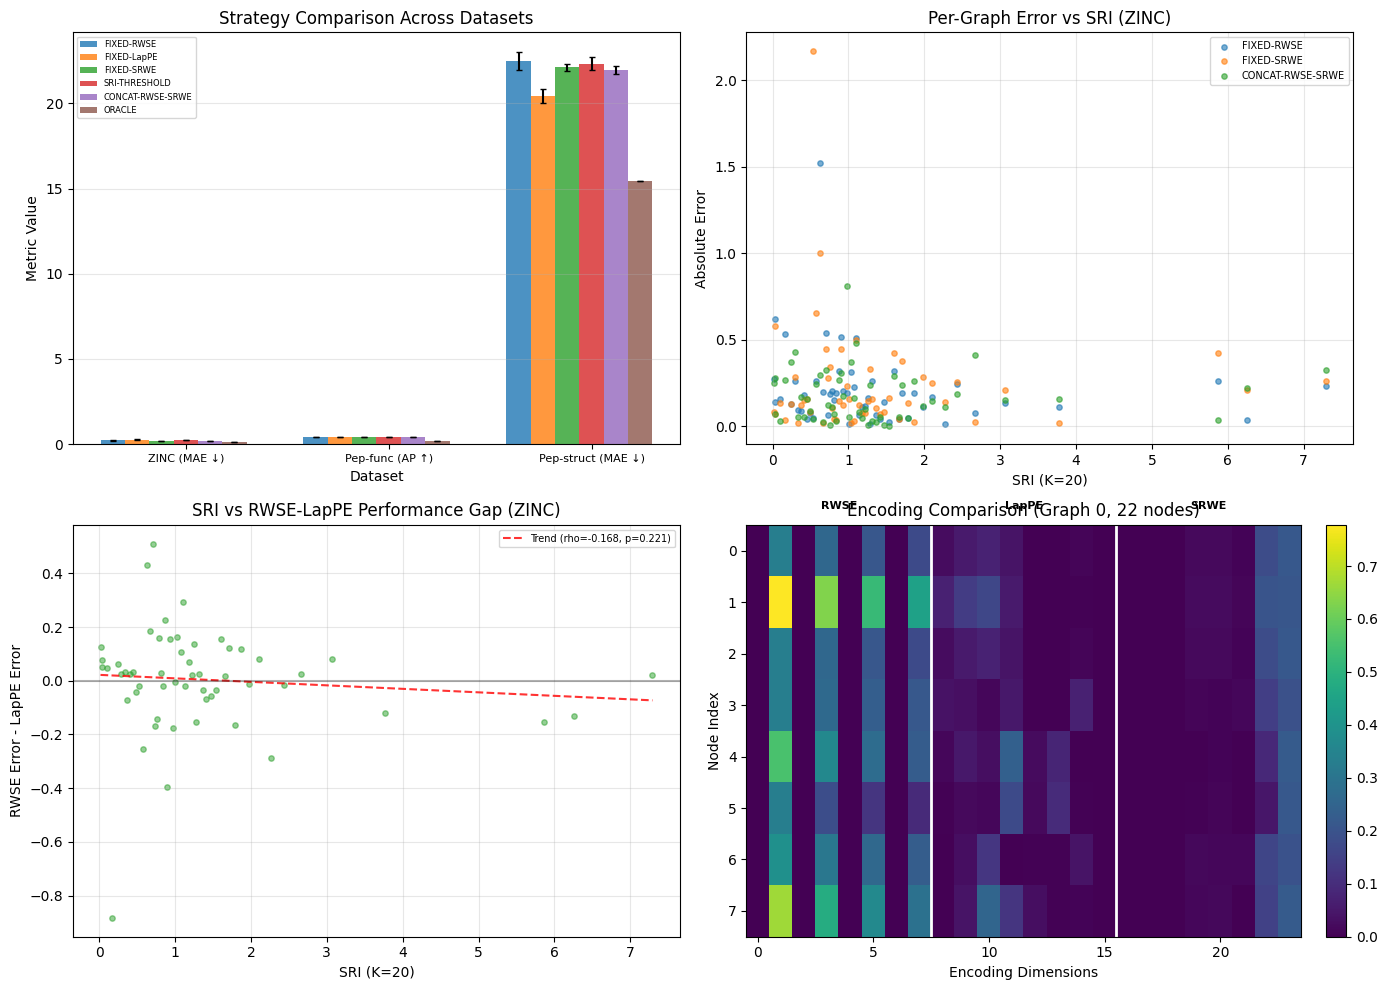

Visualization saved to results_visualization.png


In [11]:
# ── Visualization ──
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ── Plot 1: Strategy comparison across datasets (bar chart) ──
ax = axes[0, 0]
ds_keys_ordered = ['zinc', 'peptides_func', 'peptides_struct']
ds_labels = ['ZINC (MAE \u2193)', 'Pep-func (AP \u2191)', 'Pep-struct (MAE \u2193)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

x = np.arange(len(ds_keys_ordered))
bar_width = 0.12

for i, strategy in enumerate(ALL_STRATEGIES):
    means = []
    stds = []
    for ds_key in ds_keys_ordered:
        r = results_summary.get(ds_key, {}).get(strategy, {})
        if r:
            means.append(r['mean'])
            stds.append(r['std'])
        else:
            means.append(0)
            stds.append(0)

    # For Peptides-func (AP, higher is better), keep as is
    # For others (MAE, lower is better), keep as is
    offset = (i - len(ALL_STRATEGIES) / 2) * bar_width
    ax.bar(x + offset, means, bar_width, yerr=stds, label=strategy,
           color=colors[i % len(colors)], capsize=2, alpha=0.8)

ax.set_xlabel('Dataset')
ax.set_ylabel('Metric Value')
ax.set_title('Strategy Comparison Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(ds_labels, fontsize=8)
ax.legend(fontsize=6, loc='upper left')
ax.grid(axis='y', alpha=0.3)

# ── Plot 2: Per-graph prediction errors on ZINC (scatter) ──
ax = axes[0, 1]
for strategy in ['FIXED-RWSE', 'FIXED-SRWE', 'CONCAT-RWSE-SRWE']:
    errors = [g['errors'].get(strategy, 0) for g in all_zinc_graphs]
    sris = [g['sri_K20'] for g in all_zinc_graphs]
    ax.scatter(sris, errors, label=strategy, alpha=0.6, s=15)

ax.set_xlabel('SRI (K=20)')
ax.set_ylabel('Absolute Error')
ax.set_title('Per-Graph Error vs SRI (ZINC)')
ax.legend(fontsize=7)
ax.grid(alpha=0.3)

# ── Plot 3: SRI vs RWSE-LapPE gap ──
ax = axes[1, 0]
ax.scatter(sri_vals, gaps, alpha=0.5, s=15, color='#2ca02c')
# Add trend line
if len(sri_vals) > 1:
    z = np.polyfit(sri_vals, gaps, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(sri_vals), max(sri_vals), 50)
    ax.plot(x_line, p(x_line), 'r--', alpha=0.8,
            label=f'Trend (rho={rho_gap:.3f}, p={pval_gap:.3f})')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('SRI (K=20)')
ax.set_ylabel('RWSE Error - LapPE Error')
ax.set_title('SRI vs RWSE-LapPE Performance Gap (ZINC)')
ax.legend(fontsize=7)
ax.grid(alpha=0.3)

# ── Plot 4: Encoding heatmaps for first graph ──
ax = axes[1, 1]
if parsed_graphs:
    g = parsed_graphs[0]
    # Show RWSE, LapPE, SRWE side by side for first few nodes
    n_show = min(8, g['num_nodes'])
    combined = np.concatenate([
        g['rwse'][:n_show, :8],
        g['lappe'][:n_show, :8],
        g['srwe'][:n_show, :8],
    ], axis=1)

    im = ax.imshow(combined, aspect='auto', cmap='viridis')
    ax.set_xlabel('Encoding Dimensions')
    ax.set_ylabel('Node Index')
    ax.set_title(f'Encoding Comparison (Graph 0, {g["num_nodes"]} nodes)')

    # Add separators
    ax.axvline(x=7.5, color='white', linewidth=2)
    ax.axvline(x=15.5, color='white', linewidth=2)
    ax.text(3.5, -0.8, 'RWSE', ha='center', fontsize=8, fontweight='bold')
    ax.text(11.5, -0.8, 'LapPE', ha='center', fontsize=8, fontweight='bold')
    ax.text(19.5, -0.8, 'SRWE', ha='center', fontsize=8, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('results_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print("Visualization saved to results_visualization.png")